## Лабораторная работа №3

## Вариант №6 (5/1,4)

## Выполнил: ст. гр. М19-ТС Каляев А.О.

1. Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).
2. Удалите дубликаты строк в наборе данных, приведите размер набора данных до и после данной операции.
3. Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая).
4. Выполните масштабирование количественных признаков. Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию).
5. Выполните замену категориальных признаков, выберите и обоснуйте способ замены.
6. Оцените корреляцию между признаками и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации).
7. Заполните пропущенные значения в данных.
8. Решите поставленную задачу классификации в соответствии с заданием. При подборе параметров классификатора используйте метод GridSearchCV и перекрёстную проверку (изучите возможные для изменения параметры классификации). Оцените качество работы классификатора.

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy import interp
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (auc, roc_curve, 
                             precision_recall_curve, 
                             average_precision_score)

#### 1. Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).
##### Набор данных: titanic
##### Классификаторы: классификатор K ближайших соседей (задаётся количество ближайших объектов), логический классификатор (бинарное решающее дерево)
##### Признаки и параметры:
pclass (класс билета): 1 - 1 класс; 2 - 2 класс; 3 - 3 класс

survived (выживание): 0 - Нет; 1 - Да

name (имя):	любой

sex	(пол): female - женский, male - мужской

age	(возраст): любой числовой

sibsp (число братьев, сестер, супругов): любой числовой

parch (число родителей, детей): любой числовой

fare (цена билета): любой числовой

ticket (номер билета): любой

cabin (номер каюты): любой

embarked (порт погрузки): C = Cherbourg, Q = Queenstown, S = Southampton

boat (номер спасательной шлюпки): любой

body (идентификационный номер тела): любой

home.dest (Дом/Назначение): любой


In [2]:
titan = pd.read_csv(r'titanic3.csv', sep=';')
titan.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29,0.0,0.0,24160,"211,3375",B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,"0,9167",1.0,2.0,113781,"151,5500",C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2,1.0,2.0,113781,"151,5500",C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30,1.0,2.0,113781,"151,5500",C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1.0,2.0,113781,"151,5500",C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
drop_list = ['body', 'boat', 'name', 'cabin', 'ticket', 'home.dest']
titan.drop(drop_list, axis=1, inplace=True)
titan.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1.0,1.0,female,29,0.0,0.0,"211,3375",S
1,1.0,1.0,male,"0,9167",1.0,2.0,"151,5500",S
2,1.0,0.0,female,2,1.0,2.0,"151,5500",S
3,1.0,0.0,male,30,1.0,2.0,"151,5500",S
4,1.0,0.0,female,25,1.0,2.0,"151,5500",S


#### 2. Удалите дубликаты строк в наборе данных, приведите размер набора данных до и после данной операции.

In [4]:
dtitan = titan.drop_duplicates()
dtitan.count()
print ('До удаления дубликатов: ',titan.shape)
print ('После удаления дубликатов: ',dtitan.shape)

До удаления дубликатов:  (1310, 8)
После удаления дубликатов:  (1115, 8)


#### 3. Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая).

<AxesSubplot:xlabel='survived', ylabel='count'>

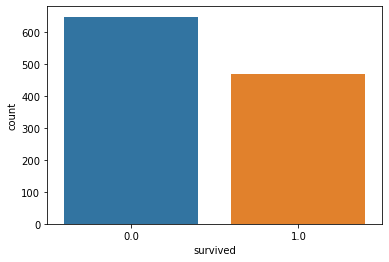

In [5]:
sns.countplot(data = dtitan, x='survived')

#### 4. Выполните масштабирование количественных признаков. Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию).

In [6]:
def cast(obj):
    if type(obj) == str:
        return float(obj.replace(',', '.'))
    else:
        return obj
dtitan['age'] = dtitan['age'].apply(lambda x: cast(x))
dtitan['fare'] = dtitan['fare'].apply(lambda x: cast(x))
dtitan['pclass'] = dtitan['pclass'].apply(lambda x: str(x))
numerical_columns = [i for i in dtitan.columns if dtitan[i].dtype.name != 'object']
categorial_columns = [i for i in dtitan.columns if dtitan[i].dtype.name == 'object']
print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['survived', 'age', 'sibsp', 'parch', 'fare']
categorial:  ['pclass', 'sex', 'embarked']


In [7]:
dtitan['age'] = dtitan['age'].fillna(dtitan['age'].median())
dtitan = dtitan.dropna().reset_index(drop=True)
print('dataset size', dtitan.shape)
dtitan.count()

dataset size (1111, 8)


pclass      1111
survived    1111
sex         1111
age         1111
sibsp       1111
parch       1111
fare        1111
embarked    1111
dtype: int64

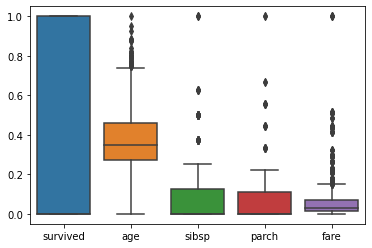

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1.0,1.0,female,0.361169,0.000,0.000000,0.412503,S
1,1.0,1.0,male,0.009395,0.125,0.222222,0.295806,S
2,1.0,0.0,female,0.022964,0.125,0.222222,0.295806,S
3,1.0,0.0,male,0.373695,0.125,0.222222,0.295806,S
4,1.0,0.0,female,0.311064,0.125,0.222222,0.295806,S


In [8]:
scaler = MinMaxScaler()
dtitan[numerical_columns] = scaler.fit_transform(dtitan[numerical_columns])
sns.boxplot(data = dtitan[numerical_columns])
plt.show()
dtitan.head()

#### 5. Выполните замену категориальных признаков, выберите и обоснуйте способ замены.

In [9]:
binary_columns = [i for i in categorial_columns if len(dtitan[i].unique()) == 2]
nonbinary_columns = [i for i in categorial_columns if len(dtitan[i].unique()) > 2]

for col in binary_columns:
    for i, unic_item in enumerate(dtitan[col].unique()):
        dtitan[col] = dtitan[col].replace(to_replace=[unic_item], value=[i])
        
dtitan_nonbinary = pd.get_dummies(dtitan[nonbinary_columns])
dtitan.drop(nonbinary_columns, axis=1, inplace=True)
dtitan = pd.concat([dtitan_nonbinary, dtitan] , axis=1)

print(dtitan.shape)
dtitan.head()

(1111, 12)


,pclass_1.0,pclass_2.0,pclass_3.0,embarked_C,embarked_Q,embarked_S,survived,sex,age,sibsp,parch,fare
0,1,0,0,0,0,1,1.0,0,0.361169,0.000,0.000000,0.412503
1,1,0,0,0,0,1,1.0,1,0.009395,0.125,0.222222,0.295806
2,1,0,0,0,0,1,0.0,0,0.022964,0.125,0.222222,0.295806
3,1,0,0,0,0,1,0.0,1,0.373695,0.125,0.222222,0.295806
4,1,0,0,0,0,1,0.0,0,0.311064,0.125,0.222222,0.295806


#### 6. Оцените корреляцию между признаками и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации).

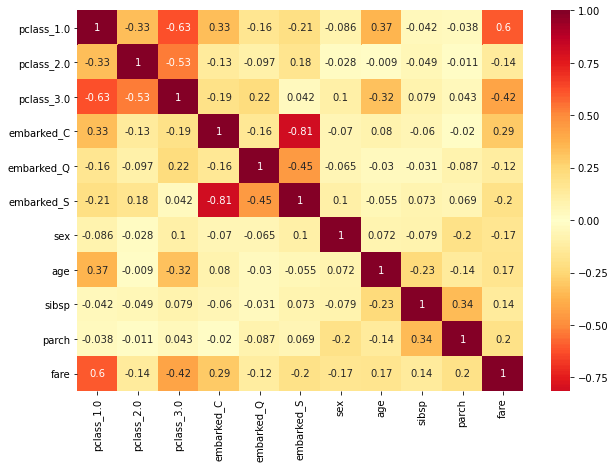

In [10]:
dtitan_corr = dtitan.drop('survived', axis=1).corr()
colors = sns.color_palette("YlOrRd_r",  n_colors=100)
colors += sns.color_palette("YlOrRd", n_colors=100)
plt.figure(figsize=(10,7))
sns.heatmap(dtitan_corr, annot = True, cmap=colors, center=0)
plt.show()

#### 7. Заполните пропущенные значения в данных. 

In [11]:
print('dataset size', dtitan.shape)
dtitan.count()

dataset size (1111, 12)


pclass_1.0    1111
pclass_2.0    1111
pclass_3.0    1111
embarked_C    1111
embarked_Q    1111
embarked_S    1111
survived      1111
sex           1111
age           1111
sibsp         1111
parch         1111
fare          1111
dtype: int64

#### 8. Решите поставленную задачу классификации в соответствии с заданием. При подборе параметров классификатора используйте метод GridSearchCV и перекрёстную проверку (изучите возможные для изменения параметры классификации). Оцените качество работы классификатора.

In [12]:
X, y = dtitan.drop('survived', axis=1), dtitan['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

In [13]:
knn = KNeighborsClassifier()
params = {'n_neighbors': list(range(1, 50))}
knn_grid = GridSearchCV(knn, params)
knn_grid.fit(X_train, y_train)
best_num = knn_grid.best_estimator_.n_neighbors
best_score = knn_grid.best_score_

print('best train score: ', best_score,
      '\t at neighbors number: ', best_num)

rnc = KNeighborsClassifier(n_neighbors=best_num)
rnc.fit(X_train, y_train)
best_score  = np.mean(y_test  == rnc.predict(X_test))
print('test score: ', best_score)

best train score:  0.7825144747725392 	 at neighbors number:  25
test score:  0.7664670658682635


In [14]:
dtc = DecisionTreeClassifier()

params = {'max_depth': list(range(1,12)), 'max_features': list(range(1,12))}

dtc_grid = GridSearchCV(dtc, params)
dtc_grid.fit(X_train, y_train)

best_features = dtc_grid.best_estimator_.max_features
best_depth = dtc_grid.best_estimator_.max_depth
best_score = dtc_grid.best_score_
print('best train score:', best_score, 
      '\t at features number:', best_features,
      '\t at depth:', best_depth)

dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
dtc.fit(X_train, y_train)
best_score  = np.mean(y_test == dtc.predict(X_test))
print('test score: ', best_score)

best train score: 0.7838130686517782 	 at features number: 9 	 at depth: 5
test score:  0.7844311377245509


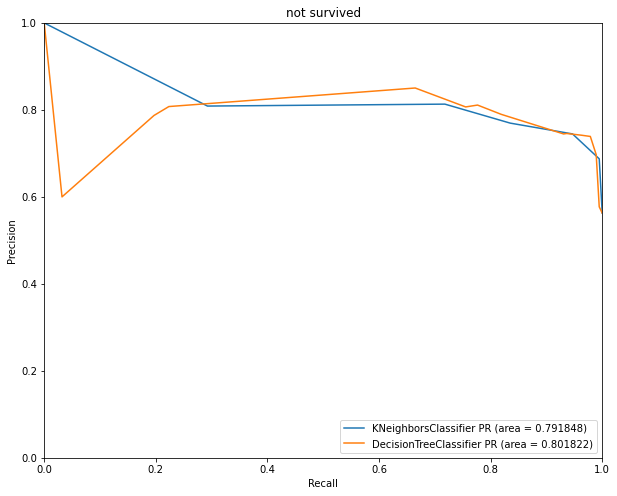

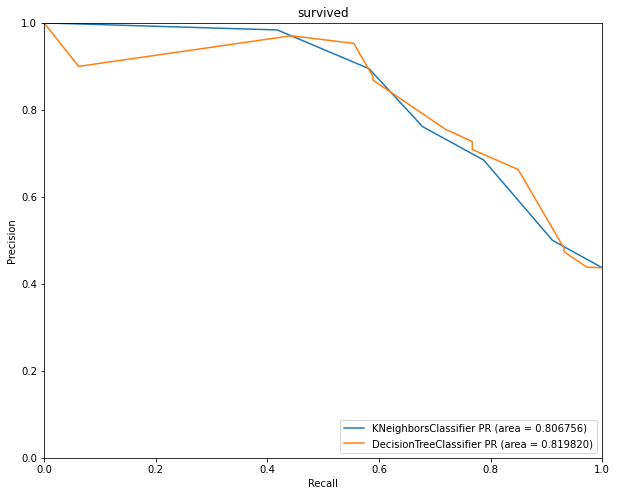

In [15]:
plt.figure(figsize=(10,8))
y_test_invers = []
for i, y in enumerate(y_test.reset_index(drop=True)):
    y_test_invers.append(1-y)
    
probas_knn0 = knn.fit(X_train, y_train).predict_proba (X_test)
probas_dtc0 = dtc.fit(X_train, y_train).predict_proba (X_test)
probas_knn1 = knn.fit(X_train, y_train).predict_proba (X_test)
probas_dtc1 = dtc.fit(X_train, y_train).predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_knn1[:,0])
aps_knn1 = average_precision_score(y_test_invers,probas_knn1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('KNeighborsClassifier', aps_knn1)) 

precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_dtc1[:,0])
aps_dtc1 = average_precision_score(y_test_invers,probas_dtc1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('not survived')
plt.show()

plt.figure(figsize=(10,8))

precision, recall, thresholds = precision_recall_curve(y_test, probas_knn0[:,1])
aps_knn0 = average_precision_score(y_test,probas_knn0[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('KNeighborsClassifier', aps_knn0)) 

precision, recall, thresholds = precision_recall_curve(y_test, probas_dtc1[:,1])
aps_dtc1 = average_precision_score(y_test,probas_dtc1[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('survived')
plt.show()

Вывод: классификаторы бинарное решающее дерево и k ближайших соседей имеют примерно одинаковые показатели качества относительно PR и ROC кривых.

Данные классификаторы правильно решают задачу предсказания класса с вероятностью 0.8~0.85 при 0,5 для 2х классов. 